## Import

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
# Import six relevant datasets
CAT_FILENAME = r'data\exoplanet.eu_catalog_08-01-26_13_03_00.csv'
df_cat = pd.read_csv(CAT_FILENAME)
df_cat.head(3)

,name,planet_status,mass,mass_error_min,mass_error_max,mass_sini,mass_sini_error_min,mass_sini_error_max,radius,radius_error_min,...,star_sp_type,star_age,star_age_error_min,star_age_error_max,star_teff,star_teff_error_min,star_teff_error_max,star_detected_disc,star_magnetic_field,star_alternate_names
0,109 Psc b,Confirmed,5.743,0.289,1.011,6.383,0.078,0.078,1.152,NaN,...,G5 IV,6.9,0.6,0.6,5600.0,80.000,80.000,NaN,NaN,HD 10697
1,112 Psc b,Confirmed,NaN,0.005,0.004,0.033,0.005,0.004,NaN,NaN,...,G0IV,NaN,NaN,NaN,5986.0,105.437,105.437,NaN,NaN,HD 12235
2,112 Psc c,Confirmed,9.866,1.781,3.190,NaN,NaN,NaN,NaN,NaN,...,G0IV,NaN,NaN,NaN,5986.0,105.437,105.437,NaN,NaN,HD 12235


In [37]:
MID_FILENAME = r'data\ExoClock IV Ephemerides_20260107\mid_time_data\all_mid_time_data.txt'
df_mid = pd.read_csv(MID_FILENAME, sep='\s+')
df_mid.tail(3)

,Planet,Tmid_(BJD_TDB),Tmid_unc.,source,ID
30341,piMenc,2.460149e+06,0.00084,space,piMenc_1372_2023-07-23_TESS
30342,piMenc,2.460156e+06,0.00095,space,piMenc_1373_2023-07-30_TESS
30343,piMenc,2.460175e+06,0.00110,space,piMenc_1376_2023-08-18_TESS


In [38]:
T0P_FILENAME = r'data\ExoClock IV Ephemerides_20260107\catalogue_of_ephemerides.txt'
df_t0p = pd.read_csv(T0P_FILENAME, sep='\s+')
df_t0p.tail(3)

,Planet,T0_(BJD_TDB),T0_unc.,P_(days),P_unc.
617,XO-6b,2.459424e+06,0.000070,3.764992,4.600000e-07
618,XO-7b,2.459567e+06,0.000072,2.864133,4.700000e-07
619,piMenc,2.459385e+06,0.000150,6.267821,1.300000e-06


In [39]:
T0P_KOI_FILENAME = r'data\Holczer-TTV_T0P.tsv'
T0PKOI_cols = ['KOI', 'T0', 'e_T0', 'Per', 'e_Per']
df_t0pk = pd.read_csv(T0P_KOI_FILENAME, sep=';', comment='#', header=0, low_memory=False, na_values=[' ']
                     )[2:][T0PKOI_cols].reset_index(drop=True)
# Remove whitespace
df_t0pk = df_t0pk.replace(r'^\s*$', np.nan, regex=True)
# Type set
df_t0pk['KOI'] = df_t0pk['KOI'].astype(str).str.strip()
df_t0pk['T0'] = df_t0pk['T0'].astype(float) + 2454900
df_t0pk[T0PKOI_cols[2:]] = df_t0pk[T0PKOI_cols[2:]].astype(float)

df_t0pk.head(3)

,KOI,T0,e_T0,Per,e_Per
0,1.01,2.454956e+06,0.000006,2.470613,1.000000e-08
1,2.01,2.454954e+06,0.000014,2.204735,2.000000e-08
2,3.01,2.454958e+06,0.000033,4.887803,4.000000e-08


In [40]:
OC_KOI_FILENAME = r'data\Holczer-TTV_data.tsv'
KOI_cols = ['KOI', 'tn', 'N', 'O-C', 'e_O-C']
df_OCK = pd.read_csv(OC_KOI_FILENAME, sep=';', comment='#', header=0, low_memory=False,
                     )[2:][KOI_cols].reset_index(drop=True)
# Type set
df_OCK['KOI'] = df_OCK['KOI'].astype(str).str.strip()
df_OCK['N'] = df_OCK['N'].astype(int)
df_OCK['tn'] = df_OCK['tn'].astype(float) + 2454900
min2day = 1/1440
df_OCK[['O-C', 'e_O-C']] = df_OCK[['O-C', 'e_O-C']].astype(float) * min2day

df_OCK.head(3)

,KOI,tn,N,O-C,e_O-C
0,1.01,2.454956e+06,0,-0.000035,0.000063
1,1.01,2.454958e+06,1,0.000053,0.000063
2,1.01,2.454961e+06,2,-0.000026,0.000063


In [41]:
MAP_FILENAME = r'data\KOI-Kepler-map_2026.01.19_05.52.41.csv'
map_cols = ['kepoi_name', 'kepler_name']
df_MAP = pd.read_csv(MAP_FILENAME, comment='#')[map_cols]
# Extract KOI number from kepoi_name
df_MAP['KOI_no'] = (
    df_MAP['kepoi_name']
    .astype(str)
    .str.extract(r'K*(\d+\.\d+)')[0]
    .astype(float).astype(str)
)
df_MAP['kepler_name'] = (
    df_MAP['kepler_name']
    .astype(str)
    .str.replace(r'\s+', '', regex=True)
)
df_MAP.head(3)

,kepoi_name,kepler_name,KOI_no
0,K00752.01,Kepler-227b,752.01
1,K00752.02,Kepler-227c,752.02
2,K00755.01,Kepler-664b,755.01


In [42]:
TTVFIT_FILENAME = r'data\Holczer-TTV_fits.tsv'
df_ttvfit = pd.read_csv(TTVFIT_FILENAME, sep=';', comment='#', header=0, low_memory=False,
                       )[2:].reset_index(drop=True)
df_ttvfit.tail(3)

,KOI,Per,Model,Per2,e_Per2,u_Amp,Amp,e_Amp,Res,N,Mult,Ref,Kepler
263,5611.01,209.22,Cos,1051.00,35.00,,66.100,7.500,5.80,6,1,,NaN
264,5651.01,83.49,Pol,,,~,85.000,,25.00,10,1,,NaN
265,5866.01,102.31,Cos,1132.00,75.00,,70.000,12.000,11.00,10,1,,NaN


## Map KOI names with Kepler names for df_OCK and df_t0pk

In [43]:
df_t0pk2 = df_MAP.merge(
    df_t0pk,
    left_on='KOI_no', right_on='KOI',
    how='inner'
)
# Remove kepler planets already in ExoClock
exoclock_kepler_list = df_t0p.loc[df_t0p['Planet'].astype(str).str.startswith('Kepler-'), 'Planet'].unique().tolist()
planets_in_exoclock = ['Kepler-448b','Kepler-13b','Kepler-89c','Kepler-89d','Kepler-89e',
                       *exoclock_kepler_list,
                       'Kepler-1b', 'Kepler-2b', 'Kepler-3b']
print(planets_in_exoclock)

df_t0pk2 = df_t0pk2[~df_t0pk2['kepler_name'].isin(planets_in_exoclock)].reset_index(drop=True)
# Clean cols and rename
df_t0pk2 = df_t0pk2[['kepler_name', 'T0', 'e_T0', 'Per', 'e_Per']]
df_t0pk2 = df_t0pk2.rename(columns={
    'kepler_name': 'Planet',
    'T0': 'T0_(BJD_TDB)', 'e_T0': 'T0_unc.',
    'Per': 'P_(days)', 'e_Per': 'P_unc.'
})

df_t0pk2.tail(3)

['Kepler-448b', 'Kepler-13b', 'Kepler-89c', 'Kepler-89d', 'Kepler-89e', 'Kepler-5b', 'Kepler-6b', 'Kepler-7b', 'Kepler-12b', 'Kepler-17b', 'Kepler-18d', 'Kepler-41b', 'Kepler-63b', 'Kepler-76b', 'Kepler-105b', 'Kepler-396c', 'Kepler-422b', 'Kepler-435b', 'Kepler-447b', 'Kepler-854b', 'Kepler-1b', 'Kepler-2b', 'Kepler-3b']


,Planet,T0_(BJD_TDB),T0_unc.,P_(days),P_unc.
1886,Kepler-1633b,2.455049e+06,0.040518,186.407727,0.000050
1887,Kepler-1638b,2.454999e+06,0.053042,259.342058,0.000056
1888,Kepler-1639b,2.455748e+06,0.030354,9.878925,0.000030


In [44]:
# Concat t0p with t0pk2
df_t0p_merged = pd.concat([df_t0p, df_t0pk2], ignore_index=True, sort=False)
df_t0p_merged.tail(3)

,Planet,T0_(BJD_TDB),T0_unc.,P_(days),P_unc.
2506,Kepler-1633b,2.455049e+06,0.040518,186.407727,0.000050
2507,Kepler-1638b,2.454999e+06,0.053042,259.342058,0.000056
2508,Kepler-1639b,2.455748e+06,0.030354,9.878925,0.000030


In [45]:
df_OCK2 = df_MAP.merge(
    df_OCK,
    left_on='KOI_no', right_on='KOI',
    how='inner'
)

df_OCK2 = df_OCK2[~df_OCK2['kepler_name'].isin(planets_in_exoclock)].reset_index(drop=True)
# Format it to resemble df_OC
df_OCK2['Tmid_unc.'] = np.nan
df_OCK2['source'] = f'Holczer+16'
df_OCK2 = df_OCK2.merge(
    df_t0pk2,
    left_on='kepler_name', right_on='Planet',
    how='left'
)
# Clean cols and rename
df_OCK2 = df_OCK2[['kepler_name', 'tn', 'Tmid_unc.', 'source', 'P_(days)', 'P_unc.', 'N', 'O-C', 'e_O-C']]
df_OCK2 = df_OCK2.rename(columns={
    'kepler_name': 'Planet', 'N': 'epoch', 'tn': 'Tmid_(BJD_TDB)',
    'O-C': 'O-C_(days)', 'e_O-C': 'O-C_unc._(days)'
})

df_OCK2.tail(3)

,Planet,Tmid_(BJD_TDB),Tmid_unc.,source,P_(days),P_unc.,epoch,O-C_(days),O-C_unc._(days)
245201,Kepler-1639b,2.455985e+06,NaN,Holczer+16,9.878925,0.00003,24,0.002083,0.006944
245202,Kepler-1639b,2.456005e+06,NaN,Holczer+16,9.878925,0.00003,26,-0.005556,0.013889
245203,Kepler-1639b,2.456015e+06,NaN,Holczer+16,9.878925,0.00003,27,0.007639,0.013889


In [46]:
df_ttvfit2 = df_MAP.merge(
    df_ttvfit,
    left_on='KOI_no', right_on='KOI',
    how='inner'
)
ttvfit_cols = ['kepler_name', 'Model', 'Per2', 'e_Per2', 'Amp', 'e_Amp', 'Res']
df_ttvfit2 = df_ttvfit2[ttvfit_cols][df_ttvfit2.Model == 'Cos'].reset_index(drop=True)
df_ttvfit2.to_csv(r'data_cleaned\Holczer-TTV_fits_mapped.csv', index=False)
df_ttvfit2.tail(3)

,kepler_name,Model,Per2,e_Per2,Amp,e_Amp,Res
56,Kepler-953b,Cos,269.00,3.70,5.600,1.100,2.70
57,Kepler-2001c,Cos,1269.00,24.00,151.100,5.600,26.00
58,Kepler-1624b,Cos,110.25,0.94,2.120,0.680,1.70


## Clean exoplanet.eu dataset then merge with T0P

In [47]:
print(df_cat.columns)

Index(['name', 'planet_status', 'mass', 'mass_error_min', 'mass_error_max',
       'mass_sini', 'mass_sini_error_min', 'mass_sini_error_max', 'radius',
       'radius_error_min', 'radius_error_max', 'orbital_period',
       'orbital_period_error_min', 'orbital_period_error_max',
       'semi_major_axis', 'semi_major_axis_error_min',
       'semi_major_axis_error_max', 'eccentricity', 'eccentricity_error_min',
       'eccentricity_error_max', 'inclination', 'inclination_error_min',
       'inclination_error_max', 'angular_distance', 'discovered', 'updated',
       'omega', 'omega_error_min', 'omega_error_max', 'tperi',
       'tperi_error_min', 'tperi_error_max', 'tconj', 'tconj_error_min',
       'tconj_error_max', 'tzero_tr', 'tzero_tr_error_min',
       'tzero_tr_error_max', 'tzero_tr_sec', 'tzero_tr_sec_error_min',
       'tzero_tr_sec_error_max', 'lambda_angle', 'lambda_angle_error_min',
       'lambda_angle_error_max', 'impact_parameter',
       'impact_parameter_error_min', 'impa

In [48]:
# Select cols
relevant_columns = ['name', 'mass', 'mass_error_min', 'mass_error_max',
                    'mass_sini', 'mass_sini_error_min', 'mass_sini_error_max',
                    'radius', 'radius_error_min', 'radius_error_max',
                    'orbital_period', 'orbital_period_error_min', 'orbital_period_error_max',
                    'eccentricity', 'eccentricity_error_min', 'eccentricity_error_max',
                    'inclination', 'inclination_error_min', 'inclination_error_max',
                    'omega', 'omega_error_min', 'omega_error_max',
                    'star_mass', 'star_mass_error_min', 'star_mass_error_max',
                    'star_radius', 'star_radius_error_min', 'star_radius_error_max',
                    'alternate_names', 'star_name']
df_cat_relevant = df_cat[relevant_columns]

# Pick error as larger error of the two
params = ['mass', 'mass_sini', 'radius', 'orbital_period', 'eccentricity', 'omega', 'inclination', 'star_mass', 'star_radius']
for p in params:
    df_cat_relevant = df_cat_relevant.copy()
    df_cat_relevant[f'{p}_error'] = df_cat_relevant[[f'{p}_error_min', f'{p}_error_max']].abs().max(axis=1)
df_cat_relevant = df_cat_relevant[['name', 'alternate_names', 'star_name', *[col for p in params for col in (f'{p}', f'{p}_error')]]]

# Merge with new good column _key with appropriate formatting
df_left, df_right = df_t0p_merged.copy(), df_cat_relevant.copy()
# left key: Remove final Ab -> b and such
df_left['_key'] = df_left['Planet'].str.replace(r'([A-Za-z0-9])([AB])([a-z])$', r'\1\3', regex=True)
# Right key: Strip whitespace then Remove final Ab -> b and such too 
df_right['_key'] = df_right['name'].str.replace(' ', '', regex=False) \
                   .str.replace(r'([AB])([a-z])$', r'\2', regex=True)

# Manual key mapping for the rest (Alternate names for the rest)
rename_map = {
    'K2-236b': 'EPIC211945201b',
    'K2-267b': 'EPIC246851721b',
    # None: 'GJ436b', # Exists in exoplanet.eu / RV
    'TOI-1098b': 'HD110082b',
    'nu2Lupb': 'HD136352c',
    # None: 'HD209458b', # Exists in exoplanet.eu / RV
    'TOI-1430b': 'HD235088b',
    'TOI-282c': 'HD28109c',
    'TOI-282d': 'HD28109d',
    'TOI-396b': 'HR858b',
    'WASP-122b': 'KELT-14b',
    'MASCARA-3b': 'KELT-24b',
    # None: 'KELT-4Ab', # Exists in exoplanet.eu / RV
    'Kepler-448b': 'KOI-12b',
    'Kepler-13b': 'KOI-13b',
    'Kepler-89c': 'KOI-94c',
    'Kepler-89d': 'KOI-94d',
    'Kepler-89e': 'KOI-94e',
    # None: 'Kepler-76b', # Exists in exoplanet.eu / Other
    # None: 'Kepler-854b', # False positive planet
    # None: 'TIC257060897b', # Exists but not in TEPCat
    'TOI-150b': 'TOI-150.01',
    'TOI-216c': 'TOI-216.01',
    'TOI-216b': 'TOI-216.02',
    'HAT-P-10b': 'WASP-11b',
    'KELT-22b': 'WASP-173b'
}
df_right['_key'] = df_right['_key'].replace(rename_map)

df_right.head(3)

,name,alternate_names,star_name,mass,mass_error,mass_sini,mass_sini_error,radius,radius_error,orbital_period,...,eccentricity_error,omega,omega_error,inclination,inclination_error,star_mass,star_mass_error,star_radius,star_radius_error,_key
0,109 Psc b,HD 10697 b,109 Psc,5.743,1.011,6.383,0.078,1.152,NaN,1075.4,...,0.009,112.816,5.448,86.116,20.530,1.13,0.030,1.790,0.1700,109Pscb
1,112 Psc b,HD 12235 b,112 Psc,NaN,0.005,0.033,0.005,NaN,NaN,4.4,...,0.254,279.492,67.524,NaN,NaN,1.10,0.133,1.801,0.0725,112Pscb
2,112 Psc c,HD 12235 c,112 Psc,9.866,3.190,NaN,NaN,NaN,NaN,36336.7,...,0.154,79.772,31.067,47.738,12.651,1.10,0.133,1.801,0.0725,112Pscc


In [49]:
# Test to see output
df_left.to_csv(r"data_intermediate\df_left_test.csv", index=False)
df_right.to_csv(r"data_intermediate\df_right_test.csv", index=False)

# Merge~!
df_t0p_cat = df_left.merge(
    df_right,
    on='_key',
    how='left'
).drop(columns='_key')

# Drop 'alternate_names' cols
df_t0p_cat = df_t0p_cat.drop(columns=['alternate_names'])
# Differentiate between ExoClock name and exoplanet.eu name
df_t0p_cat = df_t0p_cat.rename(columns={
    'Planet': 'name_exoclock+holczer',
    'name': 'name_exoplanet.eu',
})
# Export and show
EXPORT_FILENAME = r'data_intermediate\merged_exoclock_exoplanet.eu.csv'
df_t0p_cat.to_csv(EXPORT_FILENAME, index=False)
df_t0p_cat.tail(3)

,name_exoclock+holczer,T0_(BJD_TDB),T0_unc.,P_(days),P_unc.,name_exoplanet.eu,star_name,mass,mass_error,mass_sini,...,eccentricity,eccentricity_error,omega,omega_error,inclination,inclination_error,star_mass,star_mass_error,star_radius,star_radius_error
2507,Kepler-1633b,2.455049e+06,0.040518,186.407727,0.000050,Kepler-1633 b,Kepler-1633,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.20,0.17,1.32,0.54
2508,Kepler-1638b,2.454999e+06,0.053042,259.342058,0.000056,Kepler-1638 b,Kepler-1638,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.97,0.06,0.95,0.17
2509,Kepler-1639b,2.455748e+06,0.030354,9.878925,0.000030,Kepler-1639 b,Kepler-1639,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.12,0.11,1.18,0.34


In [50]:
# Check removed left
removed_left = sorted(set(df_t0p_merged['Planet']) - set(df_t0p_cat['name_exoclock+holczer']))
removed_left

[]

## Get O-C for each mid-transit

In [51]:
# Merge by planet
df_OC = df_mid.merge(df_t0p, on='Planet', how='left')

# Acquire epoch and finally O-C [+err]
df_OC['epoch'] = np.int64(np.round(
    (df_OC['Tmid_(BJD_TDB)'] - df_OC['T0_(BJD_TDB)']) / df_OC['P_(days)']
))
df_OC['O-C_(days)'] = df_OC['Tmid_(BJD_TDB)'] - (df_OC['T0_(BJD_TDB)'] + df_OC['epoch']*df_OC['P_(days)']) 	
df_OC['O-C_unc._(days)'] = df_OC['Tmid_unc.'] + df_OC['T0_unc.'] + np.abs(
    (df_OC['epoch'] * df_OC['P_unc.'])
)

# Drop unused columns
df_OC = df_OC.drop(columns=['ID', 'T0_(BJD_TDB)', 'T0_unc.'])

# Concat with OCK2
df_OC = pd.concat([df_OC, df_OCK2], ignore_index=True, sort=False)

# Rename source
df_OC['source'] = (
    df_OC['source']
    .str.replace(r'\bliterature\b', 'Kokkori+25 (literature)', regex=True)
    .str.replace(r'\bexoclock\b', 'Kokkori+25 (exoclock)', regex=True)
    .str.replace(r'\bspace\b', 'Kokkori+25 (space)', regex=True)
)

# Exoport and show
EXPORT_FILENAME = r'data_cleaned\all_mid_time_data_with_OC.csv'
df_OC.to_csv(EXPORT_FILENAME, index=False)
df_OC.tail(3)

,Planet,Tmid_(BJD_TDB),Tmid_unc.,source,P_(days),P_unc.,epoch,O-C_(days),O-C_unc._(days)
275545,Kepler-1639b,2.455985e+06,NaN,Holczer+16,9.878925,0.00003,24,0.002083,0.006944
275546,Kepler-1639b,2.456005e+06,NaN,Holczer+16,9.878925,0.00003,26,-0.005556,0.013889
275547,Kepler-1639b,2.456015e+06,NaN,Holczer+16,9.878925,0.00003,27,0.007639,0.013889


In [52]:
# Get Number of transits recorded
df_counts = (
    df_OC['Planet']
    .value_counts()
    .reset_index(name='midtime_counts')
    .rename(columns={'index': 'Planet'})
)
df_counts.head()

,Planet,midtime_counts
0,Kepler-808b,2111
1,Kepler-1520b,2036
2,Kepler-1446b,1942
3,Kepler-407b,1593
4,Kepler-732c,1486


In [53]:
# Merge into df_t0p_cat, re-export and show
df_t0p_cat_count = df_t0p_cat.merge(
    df_counts,
    left_on='name_exoclock+holczer', right_on='Planet',
    how='left'
).drop(columns='Planet')

EXPORT_FILENAME = r'data_intermediate\merged_exoclock_exoplanet.eu+counts.csv'
df_t0p_cat_count.to_csv(EXPORT_FILENAME, index=False)
df_t0p_cat_count.tail(3)

,name_exoclock+holczer,T0_(BJD_TDB),T0_unc.,P_(days),P_unc.,name_exoplanet.eu,star_name,mass,mass_error,mass_sini,...,eccentricity_error,omega,omega_error,inclination,inclination_error,star_mass,star_mass_error,star_radius,star_radius_error,midtime_counts
2507,Kepler-1633b,2.455049e+06,0.040518,186.407727,0.000050,Kepler-1633 b,Kepler-1633,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.20,0.17,1.32,0.54,8
2508,Kepler-1638b,2.454999e+06,0.053042,259.342058,0.000056,Kepler-1638 b,Kepler-1638,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.97,0.06,0.95,0.17,5
2509,Kepler-1639b,2.455748e+06,0.030354,9.878925,0.000030,Kepler-1639 b,Kepler-1639,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.12,0.11,1.18,0.34,16


## Get data for the rest of the planets in systems present in df_t0p_cat_count

In [54]:
common_stars = set(df_t0p_cat_count['star_name']).intersection(df_cat['star_name'])
df_cat_otherplanets = df_cat[df_cat['star_name'].isin(common_stars)][relevant_columns]

# Pick error as larger error of the two (Copypasted!)
params = ['mass', 'mass_sini', 'radius', 'orbital_period', 'eccentricity', 'omega', 'inclination', 'star_mass', 'star_radius']
for p in params:
    df_cat_otherplanets = df_cat_otherplanets.copy()
    df_cat_otherplanets[f'{p}_error'] = df_cat_otherplanets[[f'{p}_error_min', f'{p}_error_max']].abs().max(axis=1)
df_cat_otherplanets = df_cat_otherplanets[['name', 'alternate_names', 'star_name', *[col for p in params for col in (f'{p}', f'{p}_error')]]]

# rename 'name' to 'name_exoplanet.eu'
df_cat_otherplanets = df_cat_otherplanets.rename(columns={
    'name': 'name_exoplanet.eu',
})

# Outer merge with df_t0p_cat_count
common_colnames = df_cat_otherplanets.columns.intersection(df_t0p_cat_count.columns).tolist()
df_t0p_cat_count_otherplanets = df_t0p_cat_count.merge(
    df_cat_otherplanets, on=common_colnames, how='outer'
).drop(columns='alternate_names')

# Counts unique planets per star_names and broadcasts back to all rows
df_t0p_cat_count_otherplanets['planet_count'] = (
    df_t0p_cat_count_otherplanets
    .groupby('star_name')['star_name']
    .transform('size')
)

# As cleanup, remove rows where 'name_exoclock' AND 'star_name' are NaN
df_t0p_cat_count_otherplanets = df_t0p_cat_count_otherplanets.dropna(subset=['name_exoclock+holczer', 'star_name'], how='all')
# Remove Kepler-854b row because it's false positive
FalsePositives = ['Kepler-854b', 'Kepler-699b', 'Kepler-706b', 'Kepler-807b', 'Kepler-486b']
df_t0p_cat_count_otherplanets = df_t0p_cat_count_otherplanets[~df_t0p_cat_count_otherplanets['name_exoclock+holczer'].isin(FalsePositives)]
# Direct value insertion for TIC 257060897 and other planets
def insertStarName(planet_name, star_name, planet_count):
    mask = (df_t0p_cat_count_otherplanets['name_exoclock+holczer'] == planet_name)
    df_t0p_cat_count_otherplanets.loc[mask, ['star_name', 'planet_count']] = [star_name, planet_count]
insertStarName('TIC257060897b', 'TIC 257060897', 1)
insertStarName('Kepler-747b', 'Kepler-747', 1)
insertStarName('Kepler-896b', 'Kepler-896', 2)
insertStarName('Kepler-896c', 'Kepler-896', 2)
insertStarName('Kepler-1794b', 'Kepler-1794', 1)

# Export
EXPORT_FILENAME = r'data_intermediate\merged_exoclock_exoplanet.eu+counts+otherplanets.csv'
df_t0p_cat_count_otherplanets.to_csv(EXPORT_FILENAME, index=False)
df_t0p_cat_count_otherplanets.tail(3)

,name_exoclock+holczer,T0_(BJD_TDB),T0_unc.,P_(days),P_unc.,name_exoplanet.eu,star_name,mass,mass_error,mass_sini,...,omega,omega_error,inclination,inclination_error,star_mass,star_mass_error,star_radius,star_radius_error,midtime_counts,planet_count
2966,Kepler-747b,2.455030e+06,0.001159,35.617588,0.000001,NaN,Kepler-747,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.0,1.0
2969,Kepler-896c,2.454971e+06,0.018402,29.542212,0.000021,NaN,Kepler-896,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.0,2.0
2970,Kepler-1794b,2.454972e+06,0.006289,9.762932,0.000007,NaN,Kepler-1794,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,139.0,1.0


## Fill in missing values with the NASA exoplanet database

In [55]:
# Import
NASA_FILENAME = r'data\PS_2026.01.13_23.21.34.csv'
df_nasa = pd.read_csv(NASA_FILENAME, comment='#')
df_nasa.head(3)

,pl_name,hostname,pl_letter,sy_snum,sy_pnum,etv_flag,soltype,pl_controv_flag,pl_refname,pl_radj,...,st_raderr1,st_raderr2,st_radlim,st_mass,st_masserr1,st_masserr2,st_masslim,rowupdate,pl_pubdate,releasedate
0,11 Com b,11 Com,b,2,1,0,Published Confirmed,0,<a refstr=TENG_ET_AL__2023 href=https://ui.ads...,NaN,...,2.85,-2.45,0.0,2.09,0.64,-0.63,0.0,2023-09-19,2023-08,2023-09-19
1,11 Com b,11 Com,b,2,1,0,Published Confirmed,0,<a refstr=LIU_ET_AL__2008 href=https://ui.adsa...,NaN,...,2.00,-2.00,0.0,2.70,0.30,-0.30,0.0,2014-05-14,2008-01,2014-05-14
2,11 Com b,11 Com,b,2,1,0,Published Confirmed,0,<a refstr=KUNITOMO_ET_AL__2011 href=https://ui...,NaN,...,NaN,NaN,NaN,2.60,0.40,-0.30,0.0,2014-07-23,2011-08,2014-07-23


In [56]:
# Sort by publication date, from latest
df_nasa_right = df_nasa.copy()
# There are THREE formats for pl_pubdate, we need to parse them individually
s = df_nasa_right['pl_pubdate'].astype(str)
out = (
    pd.to_datetime(s, format='%Y-%m-%d %H:%M', errors='coerce')
    .fillna(pd.to_datetime(s, format='%Y-%m-%d', errors='coerce'))
    .fillna(pd.to_datetime(s, format='%Y-%m', errors='coerce'))
)
# Change to datetime format
df_nasa_right['pl_pubdate'] = out.dt.date

df_nasa_right = df_nasa_right.sort_values(['pl_name', 'pl_pubdate'], ascending=[True, False])

def move_to_last_col(df, col):
    return df[[c for c in df.columns if c != col] + [col]]
df_nasa_right = move_to_last_col(df_nasa_right, 'pl_refname')
df_nasa_right = move_to_last_col(df_nasa_right, 'st_refname')

df_nasa_right.head(3)

,pl_name,hostname,pl_letter,sy_snum,sy_pnum,etv_flag,soltype,pl_controv_flag,pl_radj,pl_radjerr1,...,st_radlim,st_mass,st_masserr1,st_masserr2,st_masslim,rowupdate,pl_pubdate,releasedate,pl_refname,st_refname
0,11 Com b,11 Com,b,2,1,0,Published Confirmed,0,NaN,NaN,...,0.0,2.09,0.64,-0.63,0.0,2023-09-19,2023-08-01,2023-09-19,<a refstr=TENG_ET_AL__2023 href=https://ui.ads...,<a refstr=TENG_ET_AL__2023 href=https://ui.ads...
2,11 Com b,11 Com,b,2,1,0,Published Confirmed,0,NaN,NaN,...,NaN,2.60,0.40,-0.30,0.0,2014-07-23,2011-08-01,2014-07-23,<a refstr=KUNITOMO_ET_AL__2011 href=https://ui...,<a refstr=KUNITOMO_ET_AL__2011 href=https://ui...
1,11 Com b,11 Com,b,2,1,0,Published Confirmed,0,NaN,NaN,...,0.0,2.70,0.30,-0.30,0.0,2014-05-14,2008-01-01,2014-05-14,<a refstr=LIU_ET_AL__2008 href=https://ui.adsa...,<a refstr=LIU_ET_AL__2008 href=https://ui.adsa...


In [57]:
# Choose error with greater magnitude as error
params = ['pl_radj', 'pl_massj', 'pl_msinij', 'pl_orbeccen', 'pl_orbincl', 'pl_orblper', 'st_rad', 'st_mass']
for p in params:
    df_nasa_right = df_nasa_right.copy()
    df_nasa_right[f'{p}_err'] = df_nasa_right[[f'{p}err1', f'{p}err2']].abs().max(axis=1)

# Rearrange cols
cols = ['pl_name', 'hostname', 'pl_letter',	'sy_snum', 'sy_pnum', 'etv_flag', 'ttv_flag', 'soltype', 'pl_controv_flag', 
        *[col for p in params for col in (f'{p}', f'{p}_err')],
        'pl_pubdate', 'pl_refname', 'st_refname']	
df_nasa_right = df_nasa_right[cols]
df_nasa_right.head(3)

,pl_name,hostname,pl_letter,sy_snum,sy_pnum,etv_flag,ttv_flag,soltype,pl_controv_flag,pl_radj,...,pl_orbincl_err,pl_orblper,pl_orblper_err,st_rad,st_rad_err,st_mass,st_mass_err,pl_pubdate,pl_refname,st_refname
0,11 Com b,11 Com,b,2,1,0,0.0,Published Confirmed,0,NaN,...,NaN,91.33,1.8,13.76,2.85,2.09,0.64,2023-08-01,<a refstr=TENG_ET_AL__2023 href=https://ui.ads...,<a refstr=TENG_ET_AL__2023 href=https://ui.ads...
2,11 Com b,11 Com,b,2,1,0,0.0,Published Confirmed,0,NaN,...,NaN,NaN,NaN,NaN,NaN,2.60,0.40,2011-08-01,<a refstr=KUNITOMO_ET_AL__2011 href=https://ui...,<a refstr=KUNITOMO_ET_AL__2011 href=https://ui...
1,11 Com b,11 Com,b,2,1,0,0.0,Published Confirmed,0,NaN,...,NaN,94.80,1.5,19.00,2.00,2.70,0.30,2008-01-01,<a refstr=LIU_ET_AL__2008 href=https://ui.adsa...,<a refstr=LIU_ET_AL__2008 href=https://ui.adsa...


In [58]:
# Create 6 separate dfs for data that has valid radj, massj, msinij, orbeccen, orbincl, orblper at latest publication date
def filter_df_by_nonan_col(df, col, mode='pl'):
    primary_cols = [f'{col}', f'{col}_err', f'pl_pubdate']
    fallback_cols = [f'{col}', f'pl_pubdate']
    # Picks latest publication where value and its err are NOT nan
    mask = df[primary_cols].notna().all(axis=1)
    # Fallback: Picks latest publication where value is NOT nan but no error reported
    if not mask.any():
        mask = df[fallback_cols].notna().all(axis=1)
    
    df_masked = df[mask]
    df_latestpub = df_masked.loc[df_masked.groupby('pl_name')[f'pl_pubdate'].idxmax()]
    
    # Rename column
    df_latestpub = df_latestpub.rename(columns={
        'pl_pubdate': f'{col}_pubdate',
        f'{mode}_refname': f'{col}_refname',
    })

    # Stellar-wise: take latest stellar parameter per host, then map to all planets
    if mode == 'st':
        idx = df_latestpub.groupby('hostname')[f'{col}_pubdate'].idxmax()
        stellar_latest = df_latestpub.loc[idx, ['hostname', col, f'{col}_err',
                                                f'{col}_pubdate', f'{col}_refname']]
        df_latestpub = df_latestpub.drop(columns=[col, f'{col}_err',
                                                  f'{col}_pubdate', f'{col}_refname'])
        df_latestpub = df_latestpub.merge(stellar_latest, on='hostname', how='left')
    
    exclusive_cols = cols[:3] + primary_cols[:2] + [f'{col}_pubdate', f'{col}_refname']
    return df_latestpub[exclusive_cols]

df_list = [filter_df_by_nonan_col(df_nasa_right, pcol, mode=pcol[:2]) for pcol in params]
keys = cols[:3]

# Merging time!
df_nasa_right_latest = (
    df_list[0].merge(df_list[1], on=keys, how='outer')
       .merge(df_list[2], on=keys, how='outer')
       .merge(df_list[3], on=keys, how='outer')
       .merge(df_list[4], on=keys, how='outer')
       .merge(df_list[5], on=keys, how='outer')
       .merge(df_list[6], on=keys, how='outer')
       .merge(df_list[7], on=keys, how='outer')
)
EXPORT_FILENAME = r'data_intermediate\nasa_tofillnans.csv'
df_nasa_right_latest.to_csv(EXPORT_FILENAME, index=False)
df_nasa_right_latest.head(3)

,pl_name,hostname,pl_letter,pl_radj,pl_radj_err,pl_radj_pubdate,pl_radj_refname,pl_massj,pl_massj_err,pl_massj_pubdate,...,pl_orblper_pubdate,pl_orblper_refname,st_rad,st_rad_err,st_rad_pubdate,st_rad_refname,st_mass,st_mass_err,st_mass_pubdate,st_mass_refname
0,11 Com b,11 Com,b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2023-08-01,<a refstr=TENG_ET_AL__2023 href=https://ui.ads...,13.76,2.85,2023-08-01,<a refstr=TENG_ET_AL__2023 href=https://ui.ads...,2.09,0.64,2023-08-01,<a refstr=TENG_ET_AL__2023 href=https://ui.ads...
1,11 UMi b,11 UMi,b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2009-10-01,<a refstr=DOLLINGER_ET_AL__2009 href=https://u...,29.79,2.84,2017-03-01,<a refstr=STASSUN_ET_AL__2017 href=https://ui....,2.78,0.69,2017-03-01,<a refstr=STASSUN_ET_AL__2017 href=https://ui....
2,14 And b,14 And,b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,11.55,1.12,2023-08-01,<a refstr=TENG_ET_AL__2023 href=https://ui.ads...,1.78,0.43,2023-08-01,<a refstr=TENG_ET_AL__2023 href=https://ui.ads...


In [59]:
# Merge with hostname as key
# The exoclock planet names are simply the NASA Exoplanet Database stripped strings.

# key01: host name
df_t0p_cat_count_otherplanets_left = df_t0p_cat_count_otherplanets.copy()
df_t0p_cat_count_otherplanets_left['_key01'] = (
    df_t0p_cat_count_otherplanets['name_exoclock+holczer']
    # 1) remove final lowercase letter
    .str.replace(r'[a-z]$', '', regex=True)
    # 2) put space before final capital letter (planet host)
    .str.replace(r'([A-Z])$', r' \1', regex=True)
    # 3) add space between leading letters and numbers (only if no hyphen)
    .str.replace(r'^([A-Z]+)(\d)', r'\1 \2', regex=True)
    # EXCEPTION: undo space for K2
    .str.replace(r'^K 2-', 'K2-', regex=True)
)
# Manual key01 replacement (5 edge cases)
replacements = {
    r'^55Cnc$': '55 Cnc',
    r'^TOI-150\.01$': 'TOI-150',
    r'^TOI-2152 A$': 'TOI-2152',
    r'^TOI-216\.0[12]$': 'TOI-216',
    r'^piMen$': 'HD 39091',
}
df_t0p_cat_count_otherplanets_left['_key01'] = df_t0p_cat_count_otherplanets_left['_key01'].replace(replacements, regex=True)
# Project the obtained key01 to the rest of the rows with shared 'star_name'
df_t0p_cat_count_otherplanets_left['_key01'] = (
    df_t0p_cat_count_otherplanets_left
    .groupby('star_name')['_key01']
    .transform('first')
)

# key02: planet identifier
df_t0p_cat_count_otherplanets_left['_key02'] = df_t0p_cat_count_otherplanets_left['name_exoplanet.eu'].str[-1]
# Manual key-in
df_t0p_cat_count_otherplanets_left.loc[df_t0p_cat_count_otherplanets_left['name_exoclock+holczer'] == 'TIC257060897b', '_key02'] = 'b'
df_t0p_cat_count_otherplanets_left.loc[df_t0p_cat_count_otherplanets_left['name_exoclock+holczer'] == 'Kepler-747b', '_key02'] = 'b'
df_t0p_cat_count_otherplanets_left.loc[df_t0p_cat_count_otherplanets_left['name_exoclock+holczer'] == 'Kepler-896c', '_key02'] = 'c'
df_t0p_cat_count_otherplanets_left.loc[df_t0p_cat_count_otherplanets_left['name_exoclock+holczer'] == 'Kepler-1794b', '_key02'] = 'b'

# Merge with key01 and key02 as keys
df_t0p_cat_nasa = df_t0p_cat_count_otherplanets_left.merge(
    df_nasa_right_latest, left_on=['_key01', '_key02'], right_on=['hostname', 'pl_letter'], how='left'
)

EXPORT_FILENAME = r'data_intermediate\merged_exoclock_exoplanet.eu_nasa_merge_beforenanfill.csv'
df_t0p_cat_nasa.to_csv(EXPORT_FILENAME, index=False)
df_t0p_cat_nasa.head(3)

,name_exoclock+holczer,T0_(BJD_TDB),T0_unc.,P_(days),P_unc.,name_exoplanet.eu,star_name,mass,mass_error,mass_sini,...,pl_orblper_pubdate,pl_orblper_refname,st_rad,st_rad_err,st_rad_pubdate,st_rad_refname,st_mass,st_mass_err,st_mass_pubdate,st_mass_refname
0,NaN,NaN,NaN,NaN,NaN,55 Cnc Ab,55 Cnc A,0.84,0.2300,0.8400,...,2025-10-01,<a refstr=MOUTOU_ET_AL__2025 href=https://ui.a...,0.98,0.016,2025-10-01,<a refstr=MOUTOU_ET_AL__2025 href=https://ui.a...,1.015,0.051,2025-10-01,<a refstr=MOUTOU_ET_AL__2025 href=https://ui.a...
1,NaN,NaN,NaN,NaN,NaN,55 Cnc Ac,55 Cnc A,NaN,0.0275,0.1784,...,2025-10-01,<a refstr=MOUTOU_ET_AL__2025 href=https://ui.a...,0.98,0.016,2025-10-01,<a refstr=MOUTOU_ET_AL__2025 href=https://ui.a...,1.015,0.051,2025-10-01,<a refstr=MOUTOU_ET_AL__2025 href=https://ui.a...
2,NaN,NaN,NaN,NaN,NaN,55 Cnc Ad,55 Cnc A,NaN,0.0800,3.8400,...,2025-10-01,<a refstr=MOUTOU_ET_AL__2025 href=https://ui.a...,0.98,0.016,2025-10-01,<a refstr=MOUTOU_ET_AL__2025 href=https://ui.a...,1.015,0.051,2025-10-01,<a refstr=MOUTOU_ET_AL__2025 href=https://ui.a...


In [60]:
# Fill in NaN values
def fill_in_nan(df, filled, filler):
    filled_cols = [f'{filled}', f'{filled}_error']
    filler_cols = [f'{filler}', f'{filler}_err']
    
    mask = df[filled_cols].isna().any(axis=1)
    df_filled = df.copy()
    df_filled.loc[mask, filled_cols] = df_filled.loc[mask, filler_cols].to_numpy()
    return df_filled

df_t0p_cat_nasa_filled = df_t0p_cat_nasa.copy()
df_t0p_cat_nasa_filled = fill_in_nan(df_t0p_cat_nasa_filled, 'mass', 'pl_massj')
df_t0p_cat_nasa_filled = fill_in_nan(df_t0p_cat_nasa_filled, 'mass_sini', 'pl_msinij')
df_t0p_cat_nasa_filled = fill_in_nan(df_t0p_cat_nasa_filled, 'radius', 'pl_radj')
df_t0p_cat_nasa_filled = fill_in_nan(df_t0p_cat_nasa_filled, 'eccentricity', 'pl_orbeccen')
df_t0p_cat_nasa_filled = fill_in_nan(df_t0p_cat_nasa_filled, 'omega', 'pl_orblper')
df_t0p_cat_nasa_filled = fill_in_nan(df_t0p_cat_nasa_filled, 'inclination', 'pl_orbincl')
df_t0p_cat_nasa_filled = fill_in_nan(df_t0p_cat_nasa_filled, 'star_mass', 'st_mass')
df_t0p_cat_nasa_filled = fill_in_nan(df_t0p_cat_nasa_filled, 'star_radius', 'st_rad')

# Only the first 27 cols AND plannet letter column
df_t0p_cat_nasa_filled = df_t0p_cat_nasa_filled.iloc[:, list(range(27)) + [df_t0p_cat_nasa_filled.columns.get_loc('pl_letter')]]
# Drop and rearrange certain columns
def move_colname_to_index(df, idx, colname):
    return df.insert(idx, colname, df.pop(colname))

for colname in ['pl_letter', 'star_name', 'name_exoplanet.eu']:
    move_colname_to_index(df_t0p_cat_nasa_filled, 1, colname)

# Export!
EXPORT_FILENAME = r'data_intermediate\merged_exoclock_exoplanet.eu_nasa_merge_afternanfill_01.csv'
df_t0p_cat_nasa_filled.to_csv(EXPORT_FILENAME, index=False)
df_t0p_cat_nasa_filled.head(3)

,name_exoclock+holczer,name_exoplanet.eu,star_name,pl_letter,T0_(BJD_TDB),T0_unc.,P_(days),P_unc.,mass,mass_error,...,omega,omega_error,inclination,inclination_error,star_mass,star_mass_error,star_radius,star_radius_error,midtime_counts,planet_count
0,NaN,55 Cnc Ab,55 Cnc A,b,NaN,NaN,NaN,NaN,0.8400,0.2300,...,110.0,54.0,89.73,24.54,0.9,0.115,0.963,0.0654,NaN,5.0
1,NaN,55 Cnc Ac,55 Cnc A,c,NaN,NaN,NaN,NaN,0.1714,0.0055,...,356.0,22.0,89.73,24.54,0.9,0.115,0.963,0.0654,NaN,5.0
2,NaN,55 Cnc Ad,55 Cnc A,d,NaN,NaN,NaN,NaN,3.8780,0.0680,...,254.0,32.0,89.73,24.54,0.9,0.115,0.963,0.0654,NaN,5.0


## Fill in the rest of the missing values!

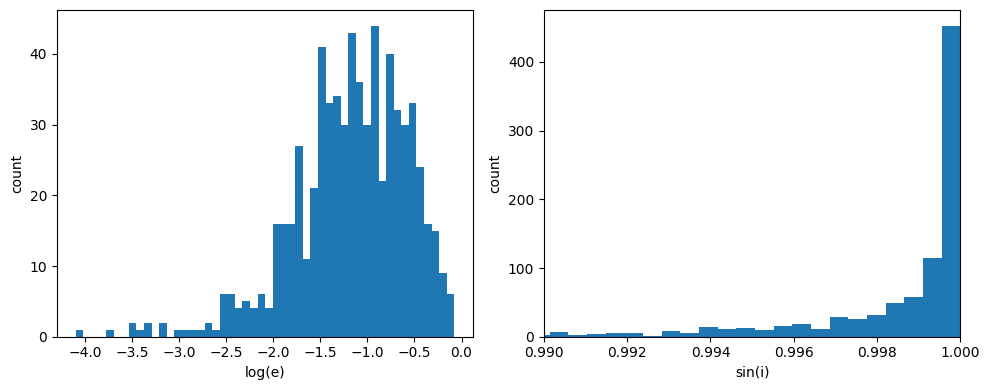

In [61]:
# Distribution of log e and sin i
# log(e)
e = df_t0p_cat_nasa_filled['eccentricity'].dropna()
e = e[e > 0]
loge = np.log10(e)
# sin i
i = df_t0p_cat_nasa_filled['inclination'].dropna()
sini = np.sin(np.deg2rad(i))

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].hist(loge, bins=50)
ax[0].set_xlabel('log(e)'); ax[0].set_ylabel('count')

ax[1].hist(sini, bins=1000)
ax[1].set_xlabel('sin(i)'); ax[1].set_ylabel('count')
ax[1].set_xlim(0.99, 1.00)

plt.tight_layout()
plt.show()

In [62]:
# Aggregated e and i by planet_count
def get_aggs(df, val):
    agg_out = df[val].dropna().agg(
        median='median',
        p16=lambda x: x.quantile(0.16),
        p84=lambda x: x.quantile(0.84),
    )
    return agg_out

e_med, e_p16, e_p84 = get_aggs(df_t0p_cat_nasa_filled, 'eccentricity')
loge_med, loge_p16, loge_p84 = np.log10([e_med, e_p16, e_p84])
loge_err = max(loge_med - loge_p16, loge_p84 - loge_med)

i_med, i_p16, i_p84 = get_aggs(df_t0p_cat_nasa_filled, 'inclination')
i_err = max(i_med - i_p16, i_p84 - i_med)

print('Median log e [+err]:', loge_med, loge_err)
print('Median i [+err]:', i_med, i_err)

Median log e [+err]: -1.154901959985743 0.7311546877074202
Median i [+err]: 88.22 3.219999999999999


In [63]:
# Fill in missing omega, e and i
df_t0p_cat_nasa_finale = df_t0p_cat_nasa_filled.copy()

nan_cols_to_fill = ['eccentricity', 'inclination', 'omega']
df_t0p_cat_nasa_finale[nan_cols_to_fill] = (
    df_t0p_cat_nasa_finale[nan_cols_to_fill]
    .fillna({'eccentricity': e_med,
             'inclination': i_med,
             'omega': 0})
)

# Fill in missing mass with m sin i / sin i
df_t0p_cat_nasa_finale['mass'] = df_t0p_cat_nasa_finale['mass'].fillna(
    df_t0p_cat_nasa_finale['mass_sini'] / np.sin(np.deg2rad(i_med))
)

df_t0p_cat_nasa_finale['mass_error'] = df_t0p_cat_nasa_finale['mass_error'].fillna(
    df_t0p_cat_nasa_finale['mass_sini_error'] / np.sin(np.deg2rad(i_med))
)

# Estiamte mass from radius from M-R relation (Muller et al. 2024)
def radius_to_mass(Rjup):
    Rjup_to_Rearth = 11.209
    R = Rjup * Rjup_to_Rearth

    # Relation cannot be used at R > 10 Earths (Thankfully none has this)
    if R > 10:
        M, Merr = np.nan, np.nan
        return M, Merr

    powerlaw_threshold = 1.51156037793
    if R < powerlaw_threshold:
        M = (R / 1.02) ** (1/0.27)
        Merr = M * np.sqrt((0.03/1.02 / 0.27)**2 + (np.log(R/1.02) * 0.04/0.27**2)**2)
    else:
        M = (R / 0.56) ** (1/0.67)
        Merr = M * np.sqrt((0.03/0.56 / 0.67)**2 + (np.log(R/0.56) * 0.05/0.67**2)**2)

    Mearth_to_Mjup = 0.00314558
    M *= Mearth_to_Mjup
    Merr *= Mearth_to_Mjup
    
    return M, Merr

# Fill in missing mass with M-R Relation
fillmask = df_t0p_cat_nasa_finale['mass'].isna() & df_t0p_cat_nasa_finale['radius'].notna()
df_t0p_cat_nasa_finale.loc[fillmask, ['mass', 'mass_error']] = (
    df_t0p_cat_nasa_finale.loc[fillmask, 'radius']
    .apply(lambda r: pd.Series(radius_to_mass(r)))
    .values
)

In [64]:
# Sort results
df_t0p_cat_nasa_finale = df_t0p_cat_nasa_finale.sort_values(by=['star_name', 'orbital_period'], ascending=[True, True]).reset_index(drop=True)
# Drop unused columns
df_t0p_cat_nasa_finale = df_t0p_cat_nasa_finale.drop(columns=['pl_letter', 'mass_sini', 'mass_sini_error'])

# Fill in missing Porb with exoclock
df_t0p_cat_nasa_finale['orbital_period'] = df_t0p_cat_nasa_finale['orbital_period'].fillna(df_t0p_cat_nasa_finale['P_(days)'])
df_t0p_cat_nasa_finale['orbital_period_error'] = df_t0p_cat_nasa_finale['orbital_period_error'].fillna(df_t0p_cat_nasa_finale['P_unc.'])


# Planet_position
df_t0p_cat_nasa_finale['planet_pos'] = (
    df_t0p_cat_nasa_finale.groupby('star_name')['orbital_period']
      .rank(method='first')
      .astype(int)
)
# Export!
EXPORT_FILENAME = r'data_intermediate\merged_exoclock_exoplanet.eu_nasa.csv'
df_t0p_cat_nasa_finale.to_csv(EXPORT_FILENAME, index=False)
df_t0p_cat_nasa_finale.head(3)

,name_exoclock+holczer,name_exoplanet.eu,star_name,T0_(BJD_TDB),T0_unc.,P_(days),P_unc.,mass,mass_error,radius,...,omega_error,inclination,inclination_error,star_mass,star_mass_error,star_radius,star_radius_error,midtime_counts,planet_count,planet_pos
0,55Cnce,55 Cnc Ae,55 Cnc A,2.459554e+06,0.0001,0.736546,1.400000e-07,0.02703,0.00135,0.1737,...,130.0,90.36,4.66,0.9,0.115,0.963,0.0654,120.0,5.0,1
1,NaN,55 Cnc Ab,55 Cnc A,NaN,NaN,NaN,NaN,0.84000,0.23000,NaN,...,54.0,89.73,24.54,0.9,0.115,0.963,0.0654,NaN,5.0,2
2,NaN,55 Cnc Ac,55 Cnc A,NaN,NaN,NaN,NaN,0.17140,0.00550,NaN,...,22.0,89.73,24.54,0.9,0.115,0.963,0.0654,NaN,5.0,3


## Potential sinunsoidal TTV flag determination for 2/3 planet systems

In [65]:
df_sinTTV = df_t0p_cat_nasa_finale.copy()
sinTTV_cols = ['period_ratio', 'mass_ratio', 'potential_sinTTV_flag',
              'TTV_pos', 'MMR', 'j', 'N', 'Delta', 'expected_Pttv']
df_sinTTV[sinTTV_cols] = np.nan

In [75]:
# 2-planet case
df_sinTTV2 = df_sinTTV.copy()[df_sinTTV.planet_count == 2].reset_index(drop=True)

# Period/Mass ratios
df_sinTTV2['period_ratio'] = (
    df_sinTTV2['orbital_period']
    / df_sinTTV2.groupby('star_name')['orbital_period'].transform('min')
)
df_sinTTV2['mass_ratio'] = (
    df_sinTTV2['mass']
    / df_sinTTV2.groupby('star_name')['mass'].transform('min')
)
# Potential sin TTV flag
df_sinTTV2['potential_sinTTV_flag'] = (
    df_sinTTV2.groupby('star_name')['period_ratio']
      .transform('max')
      .lt(4.1)
      .astype(int)
)
df_sinTTV2['potential_sinTTV_flag'] = df_sinTTV2['potential_sinTTV_flag'].fillna(0)
# TTV position
df_sinTTV2['TTV_pos'] = np.select(
    [
        (df_sinTTV2['potential_sinTTV_flag'] == 1) & (df_sinTTV2['planet_pos'] == 1),
        (df_sinTTV2['potential_sinTTV_flag'] == 1) & (df_sinTTV2['planet_pos'] == 2),
    ],
    ['inner', 'outer'],
    default=''
)
# Temporary column for MMR search
df_sinTTV2['max_period_ratio'] = (
    df_sinTTV2.groupby('star_name')['period_ratio']
              .transform('max')
)
# Find closest MMR
allowed_MMR = {
    '2:1': 2/1, '3:2': 3/2, '4:3': 4/3, '5:4': 5/4, '6:5': 6/5, '7:6': 7/6,
    '3:1': 3/1, '5:3': 5/3, '7:5': 7/5,
    '4:1': 4/1, '5:2': 5/2,
    '5:1': 5/1, '7:3': 7/3}
vals = np.array(list(allowed_MMR.values()))
keys = np.array(list(allowed_MMR.keys()))

def closest_allowed_MMR(x):
    if np.isnan(x) or x >= 4.1:
        return np.nan
    return keys[np.argmin(np.abs(vals - x))]

df_sinTTV2['MMR'] = df_sinTTV2['max_period_ratio'].apply(closest_allowed_MMR)

# Get j and N
from natsume.common import get_MMR
df_sinTTV2[['j', 'N']] = (
    df_sinTTV2['MMR']
      .apply(lambda x: pd.Series(get_MMR(x)) if isinstance(x, str) else pd.Series([np.nan, np.nan]))
)
# Get Delta
from natsume.common import get_NormalizedResonanceDistance
df_sinTTV2['Delta'] = get_NormalizedResonanceDistance(1, df_sinTTV2.max_period_ratio, df_sinTTV2.j, df_sinTTV2.N)

# Remove temporary max_period_ratio
df_sinTTV2 = df_sinTTV2.drop(columns='max_period_ratio')

def expected_pttv(g):
    inner = g.loc[g['TTV_pos'] == 'inner', 'orbital_period']
    outer = g.loc[g['TTV_pos'] == 'outer', 'orbital_period']

    if (len(inner) != 1) or (len(outer) != 1):
        return pd.Series(np.nan, index=g.index)

    Porb1 = inner.iloc[0]
    Porb2 = outer.iloc[0]
    j = g['j'].iloc[0]
    N = g['N'].iloc[0]
    Pttv = 1.0 / abs(j/Porb2 - (j-N)/Porb1)
    return pd.Series(Pttv, index=g.index)

df_sinTTV2['expected_Pttv'] = (
    df_sinTTV2
    .groupby('star_name', group_keys=False)
    .apply(expected_pttv, include_groups=False)
)

4.234502 6.594 3.0 1.0
57.6318926302492
57.6318926302492
1.1994 3.0395803 5.0 3.0
44.37251689763726
44.37251689763726
9.55288 21.05652 7.0 4.0
54.356160832729785
54.356160832729785
2.541 6.744 5.0 3.0
21.885701149425287
21.885701149425287
11.6264 27.13 7.0 4.0
60658.50615389346
60658.50615389346
2.76953 5.70588 2.0 1.0
94.7284848123728
94.7284848123728
14.339186 40.87 3.0 2.0
272.8878716290777
272.8878716290777
9.058807 21.4027 7.0 4.0
243.43359300057585
243.43359300057585
6.398042 18.8805 3.0 2.0
385.1665103690411
385.1665103690411
1.0391353 3.6451398 4.0 3.0
7.406693528048482
7.406693528048482
8.962 32.939623 4.0 3.0
101.50159395635427
101.50159395635427
3.2253993 7.3744897 7.0 4.0
52.35375901057225
52.35375901057225
9.00315 15.0 5.0 2.0
8574.428571431816
8574.428571431816
1.422614 5.3410507 4.0 3.0
21.746245693839775
21.746245693839775
9.18186 14.30511983 3.0 1.0
123.37051219004933
123.37051219004933
3.4876812 6.02976 5.0 2.0
32.31021763430717
32.31021763430717
5.4122 7.1262 4.0 1.0

In [67]:
# # 3-planet case
# df_sinTTV3 = df_sinTTV.copy()[df_sinTTV.planet_count == 3].reset_index(drop=True)

# # Period/Mass ratios
# df_sinTTV3['period_ratio'] = (
#     df_sinTTV3['orbital_period']
#     / df_sinTTV3.groupby('star_name')['orbital_period'].transform('median')
# )
# df_sinTTV3['mass_ratio'] = (
#     df_sinTTV3['mass']
#     / df_sinTTV3.groupby('star_name')['mass'].transform('median')
# )

# # See
# df_sinTTV3.to_csv('test.csv')
# df_sinTTV3.head()

In [68]:
# Merge with main df and export
key = ['name_exoplanet.eu', 'star_name']
df_sinTTV = (
    df_sinTTV
    .set_index(key)
    .fillna(
        df_sinTTV2.set_index(key)
    )
    .reset_index()
)

# Export!
EXPORT_FILENAME = r'data_cleaned\merged_potential_TTV_flagged.csv'
df_sinTTV.to_csv(EXPORT_FILENAME, index=False)
df_sinTTV.head(3)

PermissionError: [Errno 13] Permission denied: 'data_cleaned\\merged_potential_TTV_flagged.csv'